# Trying to suss commanded dither parameters from engineering data

Download `pcad8eng` level 0 files from archive using _Chaser_.  I'm using OBS_ID 5283, a ~5ksec observation.

Be advised:
- There are liekly multiple files per obsid
- There are nearly 800 columns in this file
- The number of columns and order can be different between observations, based on telemetry format governed by the _IP&CL_



In [1]:
dmmerge "pcadf19*eng0.fits" pcad_eng0.fits clob+

In [2]:
dmlist pcad_eng0.fits cols | egrep 'ROLL|PITCH|YAW' | grep COMMANDED

 215   AOCMDAC1             rad/s**2     Real4          -Inf:+Inf            COMMANDED ANGULAR ACCELERATION (ROLL)
 216   AOCMDAC2             rad/s**2     Real4          -Inf:+Inf            COMMANDED ANGULAR ACCELERATION (PITCH)
 217   AOCMDAC3             rad/s**2     Real4          -Inf:+Inf            COMMANDED ANGULAR ACCELERATION (YAW)
 221   AOCMDRT1             rad/s        Real4          -Inf:+Inf            COMMANDED ANGULAR RATE IN ACA FRAME (ROLL)
 222   AOCMDRT2             rad/s        Real4          -Inf:+Inf            COMMANDED ANGULAR RATE IN ACA FRAME (PITCH)
 223   AOCMDRT3             rad/s        Real4          -Inf:+Inf            COMMANDED ANGULAR RATE IN ACA FRAME (YAW)
 247   AODITHR1             rad          Real4          -Inf:+Inf            COMMANDED DITHER ANGLES ROLL
 248   AODITHR2             rad          Real4          -Inf:+Inf            COMMANDED DITHER ANGLES PITCH
 249   AODITHR3             rad          Real4          -Inf:+Inf            COMMA


`PITCH` and `YAW` map to `DET_Y` and `DET_Z`, I believe in that order.

## Amplitude

I'm using my off-to-the-side, handy-dandy _click-click-plot_, `ccp`, tool to plot values using matplotlib.

In [3]:
ccp pcad_eng0.fits"[cols time,AODITHR2,AODITHR3]"

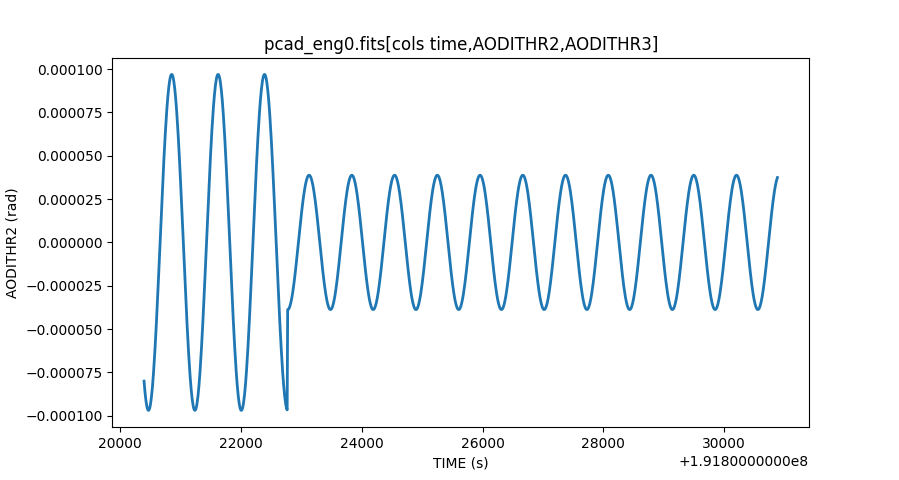

In [4]:
display < time_v_aodithr2_pitch.png

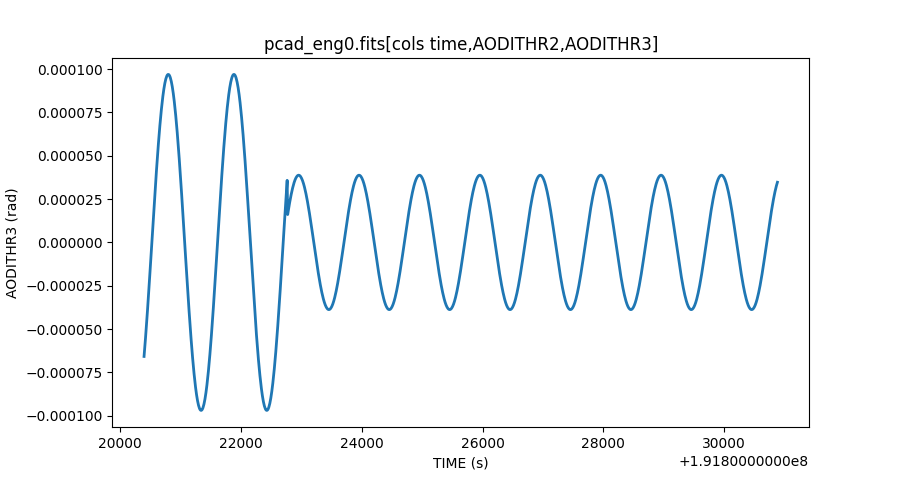

In [5]:
display < time_v_aodithr3_yaw.png

If we look at the asol file we can see the times when were in in Kalman lock and dithering.

In [6]:
dmstat ../../pcadf05283_000N001_asol1.fits.gz"[cols time]" sig- med-

time[s]
    min:	191823030.33 	      @:	1 
    max:	191828164.55 	      @:	20037 
   mean:	191825597.44 
    sum:	3.8436094959e+12 
   good:	20037 
   null:	0 



From here we see the dither ampltude in the PITCH and YAW directions vs. time.  The start of the obsevations is
at `time=191823030.33` or `23000` on the plots.  The amplitude is in **radians** whereas the values in _ocat_ are in **degrees**.  The amplitude in _ocat_ for this observations are both `0.0022` degrees. Doing the conversion:


In [7]:
python -c 'print(0.0022*3.141592/180.0)'

3.839723555555556e-05


we see that the min/max of these values matches the planned values in the _ocat_.

In [8]:
dmstat "pcad_eng0.fits[cols AODITHR2,AODITHR3][time=191823100:191828100]"

AODITHR2[rad]
    min:	-3.8779922761e-05 	      @:	478 
    max:	3.8779282477e-05 	      @:	176 
   mean:	2.9686021751e-07 
  sigma:	2.7528220443e-05 
    sum:	0.00018078787247 
   good:	609 
   null:	0 

AODITHR3[rad]
    min:	-3.8779740862e-05 	      @:	531 
    max:	3.8779828174e-05 	      @:	592 
   mean:	-3.2843007537e-08 
  sigma:	2.7426816496e-05 
    sum:	-2.000139159e-05 
   good:	609 
   null:	0 



## Frequency/Period?

This is harder.  I have not found this explict in the data.  

We can look at the `COMMANDED ANGULAR RATE` values are in (nearly) the right units so let's look at those values:


In [9]:
ccp pcad_eng0.fits"[cols time,AOCMDRT2,AOCMDRT3]"

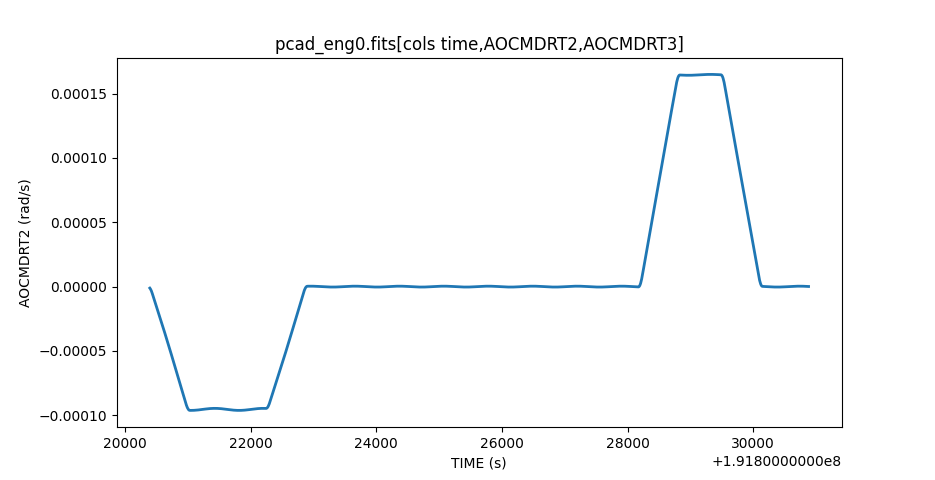

In [10]:
display < time_v_aocmdrt2_pitch.png

That doesn't really help, but if we zoom into the time period of the observations:

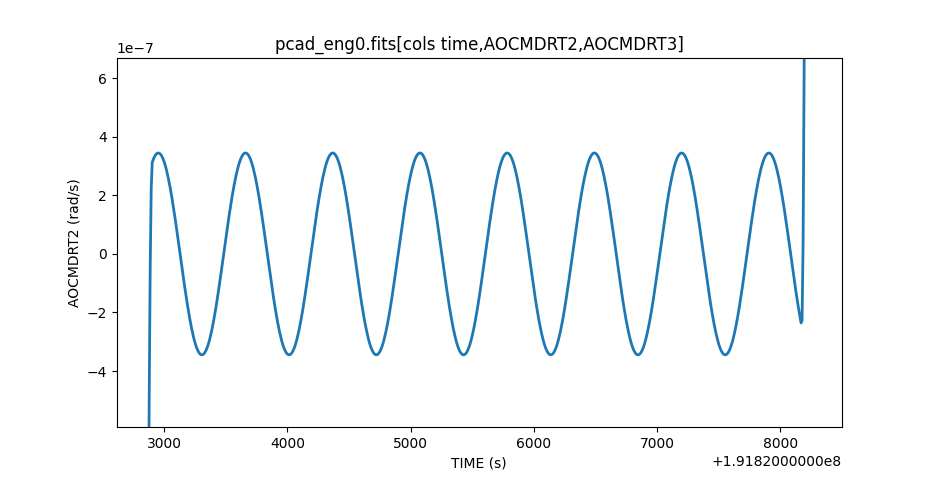

In [11]:
display < time_v_aocmdrt2_pitch_zoom.png

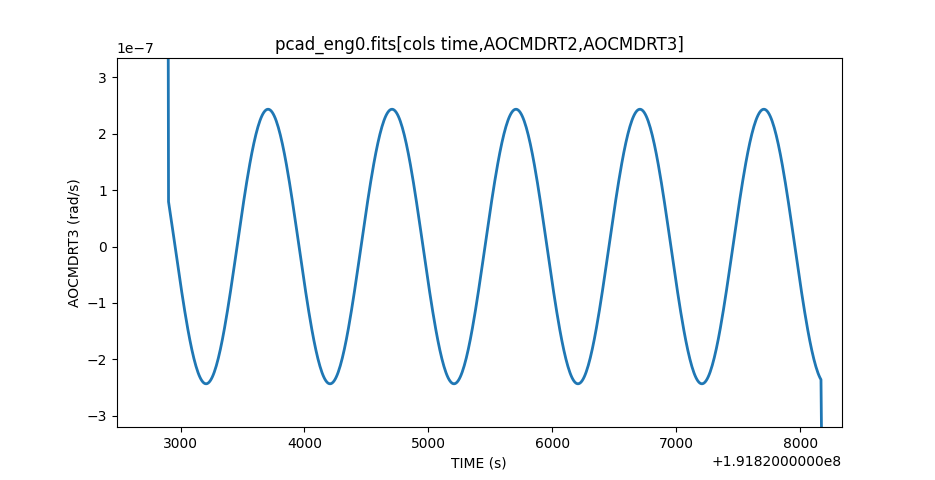

In [12]:
display < time_v_aocmdrt3_yaw_zoom.png

We see the expected dither pattern.

Looking at the range of values in the time period of the obi

In [13]:
dmstat pcad_eng0.fits"[cols time,AOCMDRT2,AOCMDRT3][time=191823100:191828100]"

TIME[s]
    min:	191823107.97 	      @:	1 
    max:	191828093.57 	      @:	609 
   mean:	191825600.77 
  sigma:	1441.5840067 
    sum:	1.1682179087e+11 
   good:	609 
   null:	0 

AOCMDRT2[rad/s]
    min:	-3.4457713127e-07 	      @:	284 
    max:	3.4457070797e-07 	      @:	241 
   mean:	1.2841670529e-10 
  sigma:	2.4269081437e-07 
    sum:	7.8205773524e-08 
   good:	609 
   null:	0 

AOCMDRT3[rad/s]
    min:	-2.4366124762e-07 	      @:	13 
    max:	2.4366062235e-07 	      @:	74 
   mean:	2.6483754142e-10 
  sigma:	1.722649511e-07 
    sum:	1.6128606273e-07 
   good:	609 
   null:	0 



The values in the _ocat_ for the "Frequency" are in units of `deg/s`. (`0.360` and `0.5091`). It's really a rate. As there are 360 degrees in one cycle, to get the period:

In [14]:
python -c 'print(1.0/(0.360/360))'
python -c 'print(1.0/(0.5091/360))'

1000.0
707.1302298173247


The values in the `pcad8eng` are in units of `rad/s`.  But trying to apply the same conversion doesn't work here

In [15]:
cat << EOM | python
rad_sec = 3.4457070797e-07
deg_sec = rad_sec * 180/3.141592
period = 1.0/(deg_sec/360.0)
print(period)
EOM

18234817.570584223


How about

In [16]:
cat << EOM | python
rad_sec = 3.4457070797e-07
freq = rad_sec/(2*3.141592)  # 2 pi radians per cycle gives cycle/sec
period = 1/freq
print(period)
EOM

18234817.570584223


same.

The period is implict in the actual values being plotted, I just cannot figure out how to derive the explict values cited in the ocat.